In [254]:
import matplotlib
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import r2_score

In [255]:
df = pd.read_csv('data1011valid.csv',encoding='UTF-8-Sig')
x = torch.tensor(df.iloc[:,[10,60,74,78,89,90,91,93,100,117,124,129,131,133,150,153,154,161,162,163,164,165,166,167,168]].to_numpy()).to(torch.float32)
y = torch.tensor(df.iloc[:,-1].to_numpy()).to(torch.float32)
x.shape

torch.Size([327, 25])

In [256]:
import torch
import torch.nn.functional as F   

class My_model(torch.nn.Module): 
    def __init__(self, input_dim):
        super(My_model, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(input_dim, 25),
            nn.ReLU(),
            nn.Linear(25, 1),
            )
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)
        return x
    
net = My_model(input_dim=x.shape[1])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-5, weight_decay=0, foreach=True)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, foreach=None, maximize=False, capturable=False)
loss_function = torch.nn.MSELoss(reduction='mean')

print(net)  # net 的结构

My_model(
  (layers): Sequential(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [257]:
#檢查
checkpoint = torch.load('model_state_dict2.pt')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
net = net.eval()

prediction = net(x).to(device)
loss = loss_function(prediction,y).to(device)

pred,actual = pd.DataFrame(prediction.data.numpy()), pd.DataFrame(y.data.numpy())
compare = pd.DataFrame(columns=['actual','predict'])
compare['actual'],compare['predict'] = y.data.numpy(), prediction.data.numpy()
compare = compare.T

loss:  14724.967


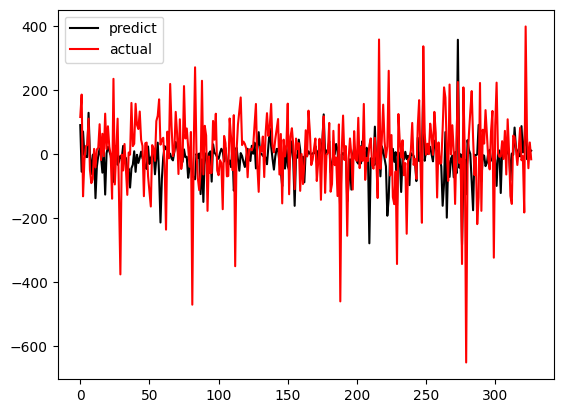

,0,1,2,3,4,5,6,7,8,9,...,317,318,319,320,321,322,323,324,325,326
actual,116.339844,186.589844,-132.041016,-18.229492,24.849609,28.360352,111.080070,-49.75000,-90.800781,-77.790039,...,17.040039,82.450195,-19.149420,-6.100586,-182.709961,399.899414,52.080078,-44.010254,36.580078,-16.089844
predict,90.997101,-55.078342,70.883850,-2.754795,-8.032627,-9.353550,129.528229,-5.77988,-61.968296,-2.914402,...,-2.599765,-6.893711,87.792786,5.725735,27.703518,125.530731,-15.713078,-0.610935,6.675702,10.861629


In [258]:
ax = plt.gca()
print('loss: ',loss.data.numpy())
compare.T.plot(kind='line',y ='predict',ax=ax,color='black')
compare.T.plot(kind='line',y ='actual',ax=ax,color='red')
plt.show()
compare
# Display all model layer weights
# for name, para in net.named_parameters():
#     print('{}: {}'.format(name, para.shape))

In [259]:
compare.T.corr()

,actual,predict
actual,1.000000,0.251884
predict,0.251884,1.000000


In [260]:
#RMSE
((np.array([(compare.T['actual']-compare.T['predict'])**2]).sum())/len(compare.T['actual']))**0.5

121.34647238735978

In [261]:
# R**2 
r2_score(compare.T['actual'],compare.T['predict'])

-0.0350638858381509